# Kernel Quadratures


**resources**

* [Doc](https://docs.google.com/document/d/1ZdYyq2q22FhzW_4KuZU6Mp8Pccg5sUGH6v3QZxo8b2E/edit)

In [1]:
import sys
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

# Jax settings
import jax
import jax.numpy as np
import objax
import numpyro
import numpyro.distributions as dist

# Gaussian process settings
from jaxkern.data.regression import simple, near_square_wave
from jaxkern.gp.exact import ExactGP
from jaxkern.kernels.stationary import RBF, RationalQuadratic
from jaxkern.gp.mean import LinearMean, ZeroMean
from jaxkern.gp.losses import negative_log_likelihood
from jaxkern.gp.optimize import optimize_model
from jaxkern.gp.utils import confidence_intervals
from jaxkern.gp.uncertain.moment import GaussHermite

import numpy as onp

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

In [2]:
# X, y, Xtest, ytest = simple(30, 400, 0.0, 0.05)
ntrain = 60
ntest = 1_000
input_cov = 0.2

output_cov = 0.2
X, y, Xtest, ytest = near_square_wave(ntrain, ntest, input_cov, output_cov)

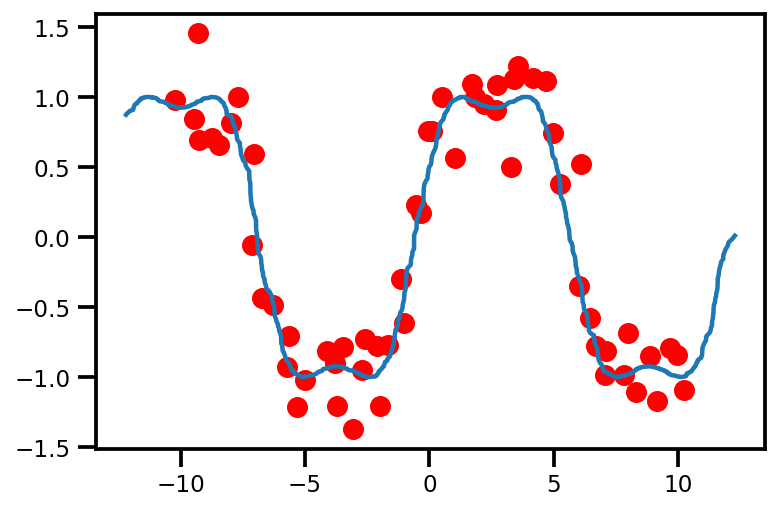

In [3]:
plt.scatter(X, y, color='red')
plt.plot(Xtest, ytest)

## Model

In [4]:
# initialize kernel
# kernel = RBF(length_scale=0.01, variance=1.0)
kernel = RationalQuadratic()

# initialize mean function
# mean = LinearMean(input_dim=1, output_dim=1)
mean = ZeroMean()

# initialize function
gp_model = ExactGP(mean=mean, kernel=kernel)

# inspect variables
for ikey, val in gp_model.vars().items():
    print(ikey, val.value)

(ExactGP).kernel(RationalQuadratic).variance [1.]
(ExactGP).kernel(RationalQuadratic).length_scale [1.]
(ExactGP).kernel(RationalQuadratic).alpha [1.]
(ExactGP).noise [0.1]


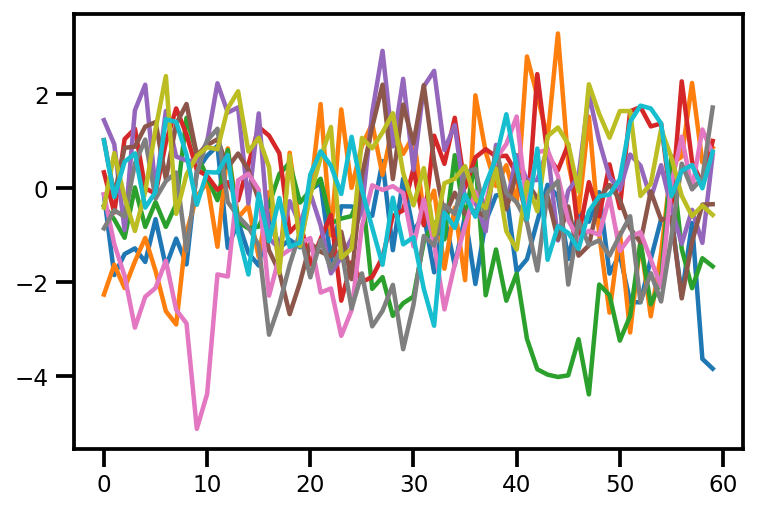

In [5]:
# generate random samples
model_dist = gp_model.forward(X)

seed = jax.random.PRNGKey(123)
y_samples = model_dist.sample((10,), seed=seed)

# plot
plt.plot(y_samples.T);

RationalQuadratic### Training

In [6]:
loss_f = jax.partial(negative_log_likelihood, gp_model)
jitted = True
n_epochs = 1_000
lr = 0.01
model, losses = optimize_model(
    model=gp_model,
    loss_f=loss_f,
    X=X, y=y,
    lr=lr,
    opt=objax.optimizer.Adam,
    n_epochs=n_epochs,
    jitted=jitted
)

100%|██████████| 1000/1000 [00:02<00:00, 338.20it/s]


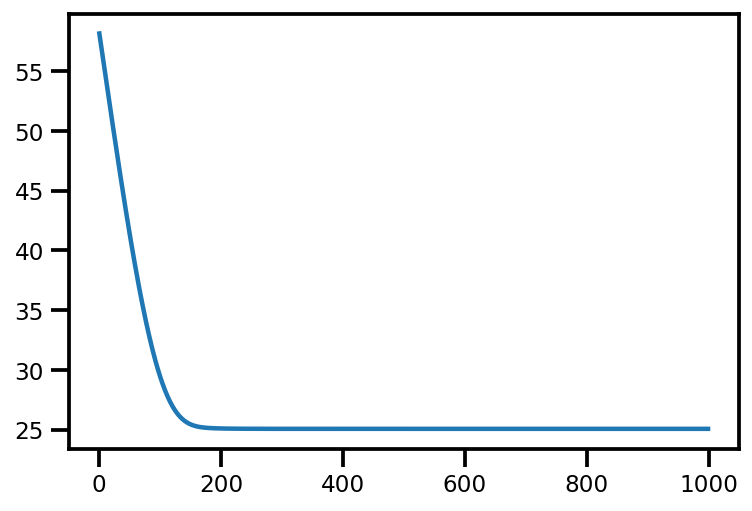

In [7]:
plt.plot(losses)

In [8]:
for ikey, val in model.vars().items():
    print(ikey, val.value, jax.nn.softplus(val.value), type(val.value), val.value.shape)

(ExactGP).kernel(RationalQuadratic).variance [1.] [1.3132617] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RationalQuadratic).length_scale [2.3997147] [2.4865746] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RationalQuadratic).alpha [0.69492704] [1.0997993] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).noise [-1.2106729] [0.2608221] <class 'jax.interpreters.xla.DeviceArray'> (1,)


In [9]:
model.cache_factorizations(X, y)

mu, cov = model.predict_f(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

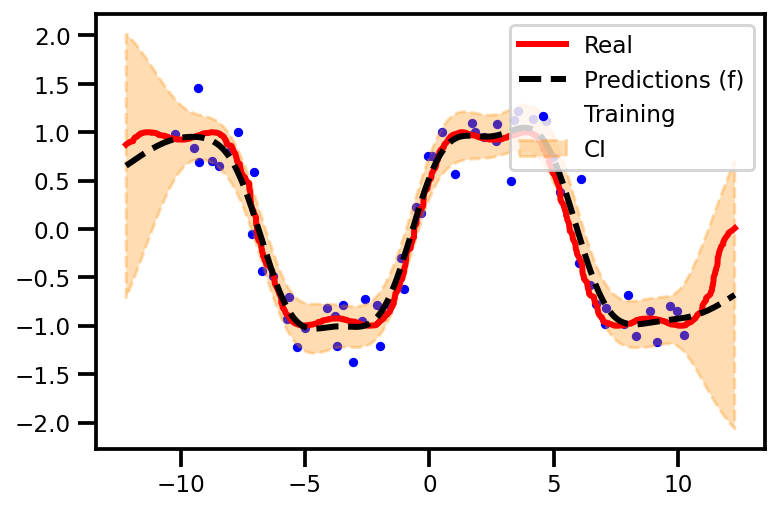

In [10]:
# plot
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (f)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, linestyle="--", label='CI', color='darkorange', alpha=0.3)

plt.legend()

In [11]:
mu, cov = model.predict_y(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

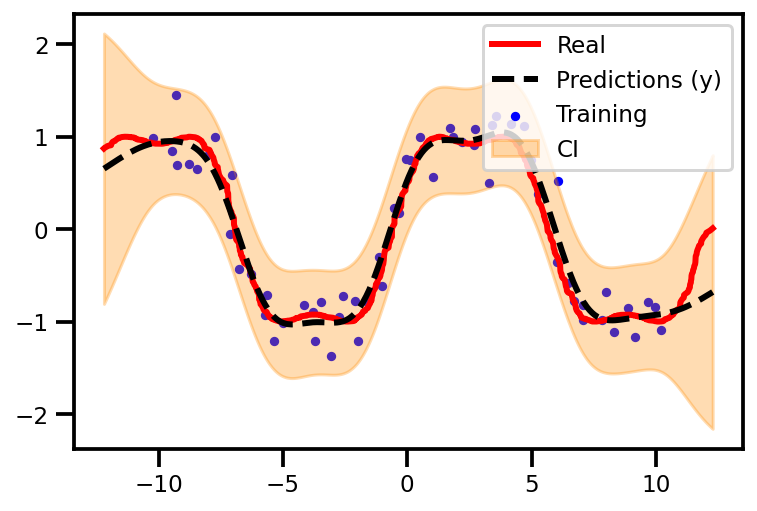

In [12]:
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

## Gauss-Hermite

In [13]:
quadrature_transform = GaussHermite(model, degree=10,  jitted=True)


In [14]:
quadrature_transform.wm

DeviceArray([4.3106525e-06, 7.5807091e-04, 1.9111581e-02, 1.3548370e-01,
             3.4464234e-01, 3.4464234e-01, 1.3548370e-01, 1.9111581e-02,
             7.5807091e-04, 4.3106525e-06], dtype=float32)

In [15]:
Xtest_cov = np.tile(np.diag(np.array([input_cov])), (ntest, 1, 1))
mean_qf, var_qf = quadrature_transform.forward(Xtest, Xtest_cov)

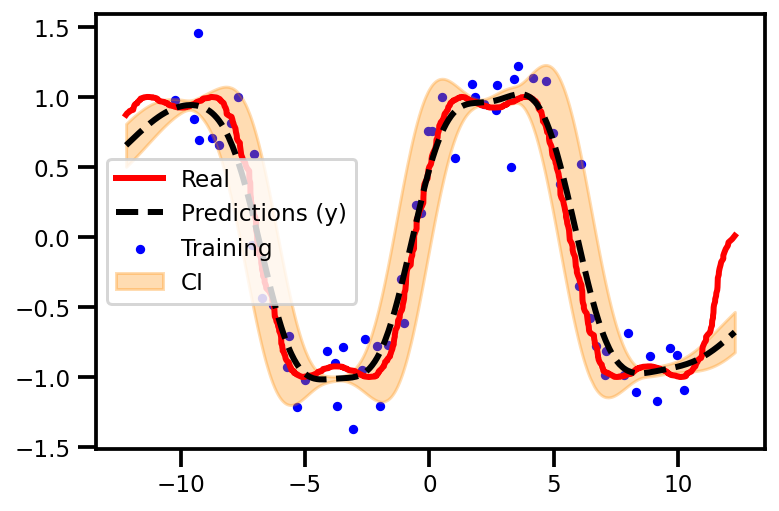

In [16]:
lb, ub = confidence_intervals(mean_qf, var_qf, 96)
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mean_qf, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

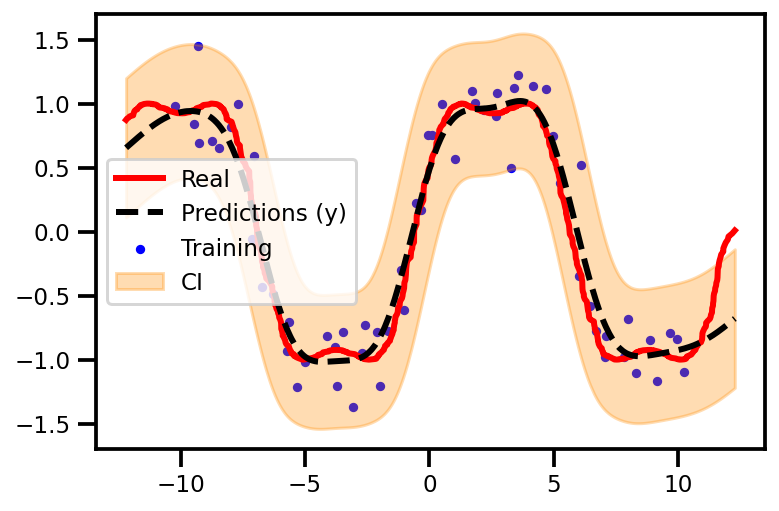

In [17]:
sigma = jax.nn.softplus(model.noise.value)

lb, ub = confidence_intervals(mean_qf, var_qf  + sigma ** 2, 96)
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mean_qf, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(
    Xtest.squeeze(), 
    lb, ub, 
    label='CI', color='darkorange', alpha=0.3)

plt.legend()

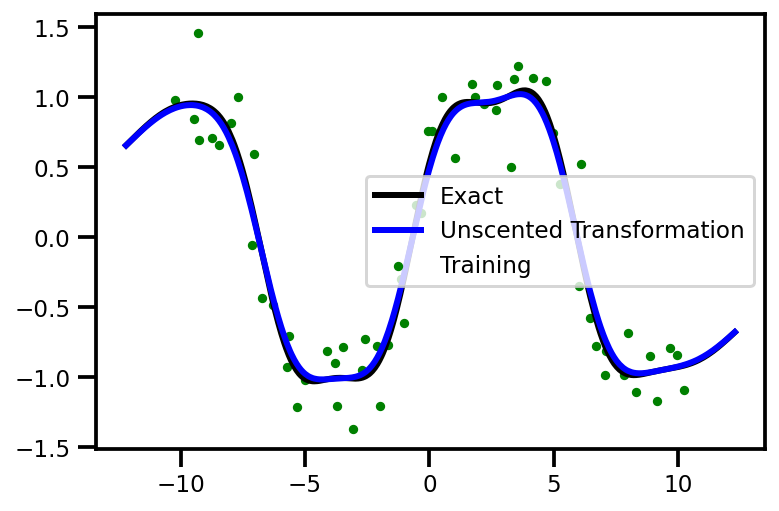

In [18]:
plt.figure()
plt.scatter(X, y, label='Training', color='green', s=10)
# plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="-", label='Exact', color='black', linewidth=3)
plt.plot(Xtest, mean_qf, linestyle="-", label='Unscented Transformation', color='blue', linewidth=3)
plt.legend()

## Quadratures

In [19]:
from jaxkern.gp.uncertain.moment import moment_transform, GaussHermite
from jaxkern.gp.predictive import predictive_mean
from jaxkern.kernels.stationary import RBF

In [20]:
def moment_transform_mean(mean_f, X, Xcov, sigma_points, wm, wc):

    # form sigma points from unit sigma-points
    # print(Xcov.shape, Xcov.shape, sigma_points.shape)
    x_ = X[:, None] + np.linalg.cholesky(Xcov) @ sigma_points
    # print("x_:", x_.shape)

    fx_ = mean_f(x_.T)
    # print("fx_:", fx_.shape, ", wm_:", wm.shape)

    # output mean
    mean_f = np.sum(fx_ * wm)

    return mean_f



In [45]:
# initialize function
gh_quad = GaussHermite(model, degree=20)

# function
mean_f = jax.partial(predictive_mean, model)
kernel_f = model.kernel


# data
Xtest_cov = np.tile(np.diag(np.array([input_cov])), (ntest, 1, 1))

# sigma points
sigma_points = gh_quad.sigma_points
wm = gh_quad.wm
wc = gh_quad.wc

sigma_points.shape, wm.shape, wc.shape


((1, 20), (20,), (20, 20))

## Mean Function

#### Scalar

In [46]:
def moment_transform_mean(mean_f, X, Xcov, sigma_points, wm, wc):

    # form sigma points from unit sigma-points
    # print(Xcov.shape, Xcov.shape, sigma_points.shape)
    
    x_ = X[:, None] + np.linalg.cholesky(Xcov) @ sigma_points
    # print("x_:", x_.shape)

    fx_ = mean_f(x_.T)
    # print("fx_:", fx_.shape, ", wm_:", wm.shape)

    # output mean
    mean_f = np.sum(fx_ * wm)

    return mean_f

In [47]:
psi0 = moment_transform_mean(mean_f, Xtest[0], Xtest_cov[0], sigma_points, wm, wc)

print(psi0)

# check shape
assert psi0.shape == ()

0.6544997


#### Vectorized

In [49]:
psi0 = jax.vmap(moment_transform_mean, in_axes=(None, 0, 0, None, None, None))(mean_f, Xtest, Xtest_cov, sigma_points, wm, wc)

# check shape
assert psi0.shape[0] == Xtest.shape[0]

## Kernel Function - X

In [50]:
def moment_transform_kernel(kernel_f, X, Xcov, sigma_points, wm, wc):

    # form sigma points from unit sigma-points
    # print(Xcov.shape, Xcov.shape, sigma_points.shape)
    
    x_ = X[:, None] + np.linalg.cholesky(Xcov) @ sigma_points
    # print("x_:", x_.shape)

    fx_ = jax.vmap(kernel_f)(x_.T, x_.T).squeeze()
    print("fx_:", fx_.shape, ", wm_:", wm.shape)

    # output mean
    mean_f = np.sum(fx_ * wm)

    return mean_f

### Scalar

In [51]:

psi0 = moment_transform_kernel(kernel_f, Xtest[0], Xtest_cov[0], sigma_points, wm, wc)

print(psi0)

# check shape
assert psi0.shape == ()

fx_: (20,) , wm_: (20,)
1.0997994


### Vectorized

In [52]:
psi0 = jax.vmap(moment_transform_kernel, in_axes=(None, 0, 0, None, None, None))(kernel_f, Xtest, Xtest_cov, sigma_points, wm, wc)


# check shape
assert psi0.shape[0] == Xtest.shape[0]

fx_: (20,) , wm_: (20,)


## Kernel Function - XY

In [53]:
def moment_transform_kernel_y(kernel_f, Y, X, Xcov, sigma_points, wm, wc):

    # form sigma points from unit sigma-points
    # print(Xcov.shape, Xcov.shape, sigma_points.shape)
    
    x_ = X[:, None] + np.linalg.cholesky(Xcov) @ sigma_points

    fx_ = jax.vmap(kernel_f, in_axes=(0, None))(x_.T, Y).squeeze()

    # output mean
    mean_f = np.sum(fx_ * wm, axis=0)

    return mean_f

#### Scalar

In [54]:
psi1 = moment_transform_kernel_y(kernel_f, X[0], Xtest[0], Xtest_cov[0], sigma_points, wm, wc)

print(psi1)

# check shape
assert psi1.shape == ()

0.8322295


#### Vectorized

In [55]:
mv = jax.vmap(moment_transform_kernel_y, in_axes=(None, None, 0, 0, None, None, None), out_axes=0)
mm = jax.vmap(mv, in_axes=(None, 0, None, None, None, None, None), out_axes=1)
psi1 = mm(kernel_f, X, Xtest, Xtest_cov, sigma_points, wm, wc)

# check shape
assert psi1.shape == (Xtest.shape[0], X.shape[0])

In [56]:
mean_ef = psi1 @ model.weights

In [57]:
psi1.shape, model.weights.shape, mean_ef.shape, Xtest.shape

((1000, 60), (60, 1), (1000, 1), (1000, 1))

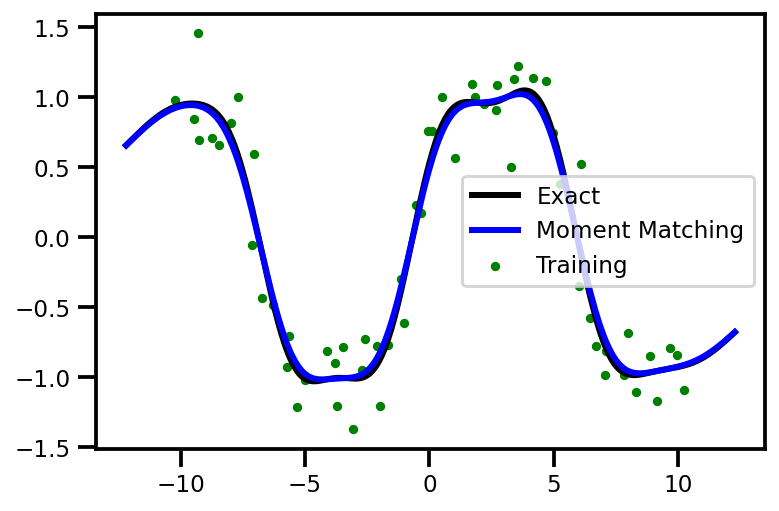

In [58]:
plt.figure()
plt.scatter(X, y, label='Training', color='green', s=10)
# plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="-", label='Exact', color='black', linewidth=3)
plt.plot(Xtest, mean_ef, linestyle="-", label='Moment Matching', color='blue', linewidth=3)
plt.legend()

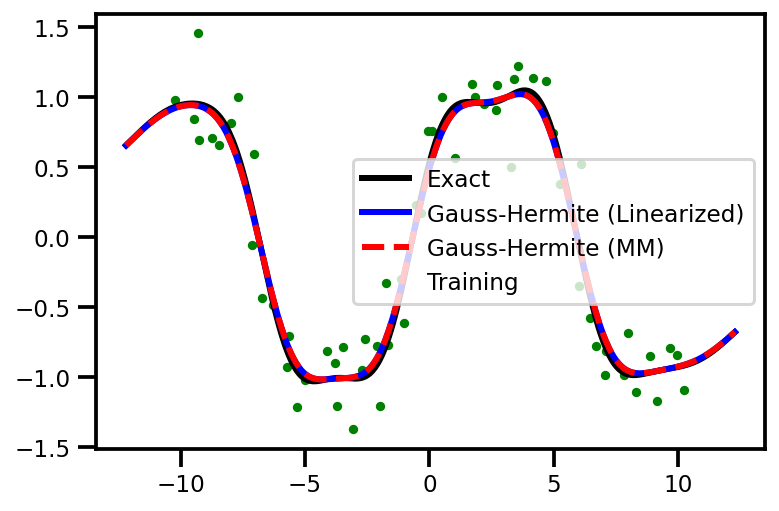

In [59]:
plt.figure()
plt.scatter(X, y, label='Training', color='green', s=10)
# plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="-", label='Exact', color='black', linewidth=3)
plt.plot(Xtest, mean_qf, linestyle="-", label='Gauss-Hermite (Linearized)', color='blue', linewidth=3)
plt.plot(Xtest, mean_ef, linestyle="--", label='Gauss-Hermite (MM)', color='red', linewidth=3)

plt.legend()

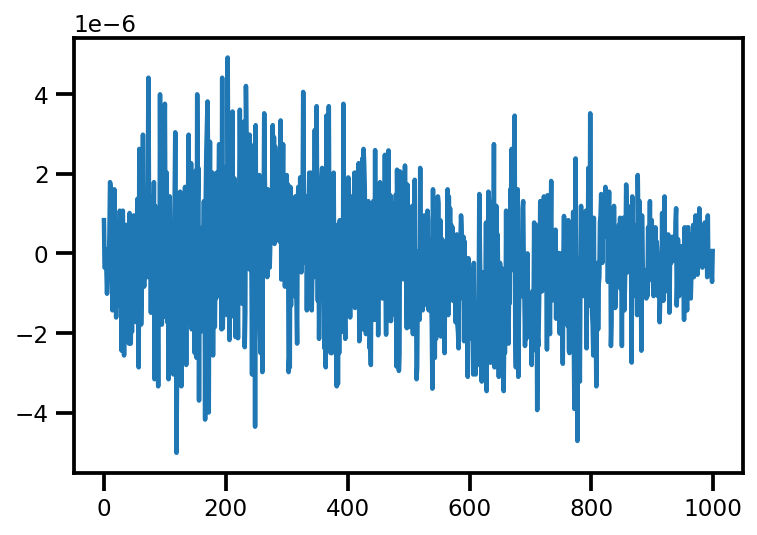

In [60]:
plt.plot(mean_qf.squeeze() - mean_ef.squeeze())

## Kernel Function - XYZ

In [61]:
def moment_transform_kernel_yz(kernel_f, Z, Y, X, Xcov, sigma_points, wm, wc):

    # form sigma points from unit sigma-points
    # print(Xcov.shape, Xcov.shape, sigma_points.shape)
    
    x_ = X[:, None] + np.linalg.cholesky(Xcov) @ sigma_points
    
    def k(x, y, z):
        return kernel_f(y, x) * kernel_f(z, x)

    fx_ = jax.vmap(k, in_axes=(0, None, None))(x_.T, Y, Z).squeeze()

    # output mean
    mean_f = np.sum(fx_ * wm, axis=0)

    return mean_f

#### Scalar

In [62]:
psi2 = moment_transform_kernel_yz(kernel_f, X[0], X[0], Xtest[0], Xtest_cov[0], sigma_points, wm, wc)

print(psi2)

# check shape
assert psi2.shape == ()

0.7005352


#### Vectorized

In [63]:
mvm = jax.vmap(moment_transform_kernel_yz, in_axes=(None, None, None, 0, 0, None, None, None), out_axes=0)
mmv = jax.vmap(mvm, in_axes=(None, None, 0, None, None, None, None, None), out_axes=1)
mmm = jax.vmap(mmv, in_axes=(None, 0, None, None, None, None, None, None), out_axes=2)
psi2 = mmm(kernel_f, X, X, Xtest, Xtest_cov, sigma_points, wm, wc)

# check shape
assert psi2.shape == (Xtest.shape[0], X.shape[0], X.shape[0])

## Variance

In [64]:
# inverse kernel matrix
k_inv = jax.scipy.linalg.inv(model.kernel(X, X) + (jax.nn.softplus(model.noise.value) ** 2) * np.eye(X.shape[0]))

# weights for kernel matrix
weights = model.weights.copy()

In [65]:
t_ = k_inv - weights @ weights.T
t_.shape

(60, 60)

In [66]:
t1 = psi0
t2 = np.trace((psi2 @ t_).T )
t3 = np.trace(psi1.T @ psi1 @ weights @ weights.T)
t3 = mean_ef**2
var_ef = t1.squeeze() - t2.squeeze() - t3.squeeze()

var_ef.shape

(1000,)

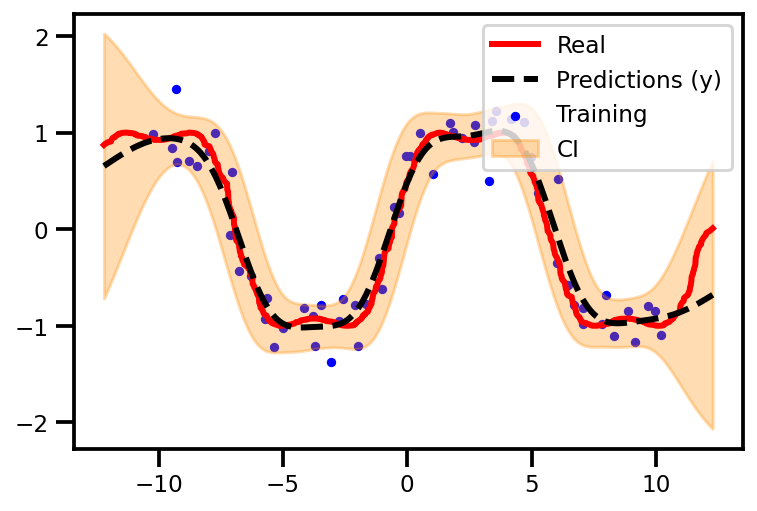

In [67]:
lb, ub = confidence_intervals(mean_ef, var_ef, 96)
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mean_qf, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

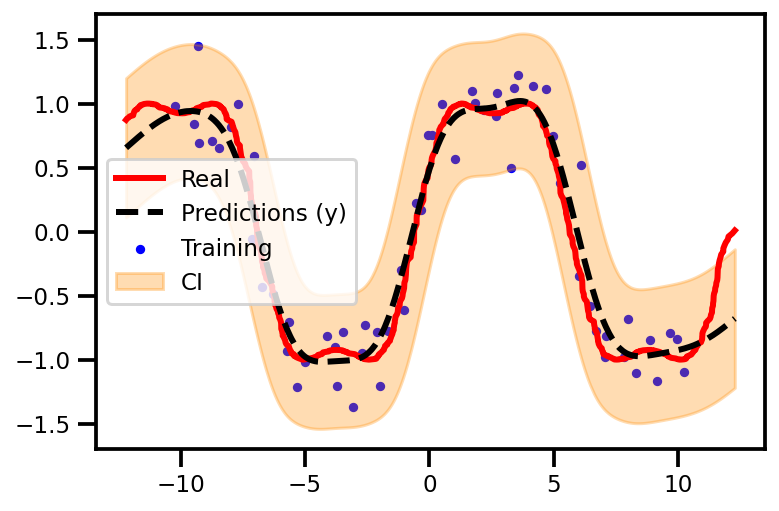

In [68]:
sigma = jax.nn.softplus(model.noise.value)

lb, ub = confidence_intervals(mean_qf, var_qf  + sigma ** 2, 96)
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mean_qf, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(
    Xtest.squeeze(), 
    lb, ub, 
    label='CI', color='darkorange', alpha=0.3)

plt.legend()